# Imports

In [1]:
import numpy as np
import pandas as pd

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/ift6758_dfwseasons 4/Allseasons.csv')

In [3]:
teams = df.groupby(['season', 'gameType'])['teamOfShooter'].unique()
game_types = df['gameType'].unique()
teams, game_types

(season  gameType
 2016    P           [Montréal Canadiens, New York Rangers, Ottawa ...
         R           [Toronto Maple Leafs, Ottawa Senators, St. Lou...
 2017    P           [Tampa Bay Lightning, New Jersey Devils, Bosto...
         R           [Winnipeg Jets, Toronto Maple Leafs, Pittsburg...
 2018    P           [Columbus Blue Jackets, Tampa Bay Lightning, B...
         R           [Montréal Canadiens, Toronto Maple Leafs, Wash...
 2019    P           [Philadelphia Flyers, Montréal Canadiens, Tamp...
         R           [Ottawa Senators, Toronto Maple Leafs, St. Lou...
 2020    P           [Pittsburgh Penguins, New York Islanders, Wash...
         R           [Philadelphia Flyers, Pittsburgh Penguins, Chi...
 Name: teamOfShooter, dtype: object,
 array(['R', 'P'], dtype=object))

# Process Data

In [4]:
def normalize_df(df):
    df_normalized = df.copy()
    df_normalized['xCoordNorm'] = np.where(df['rinkSide'] == 'left', df['xCoord'], -1 * df['xCoord'])
    df_normalized['yCoordNorm'] = np.where(df['rinkSide'] == 'left', df['yCoord'], -1 * df['yCoord'])
    return df_normalized

def compute_distance(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)


# Normalize Shot Direction
is_normalized = True
df_normalized = normalize_df(df)


# Distance from Net
net_x, net_y = (89, 0)
df_normalized['distance'] = df_normalized[['xCoordNorm', 'yCoordNorm']].apply(
    lambda row: compute_distance(row['xCoordNorm'], row['yCoordNorm'], net_x, net_y),
    axis=1
)

# Create Plot

In [5]:
df_normalized['shotType'] = df_normalized['shotType'].fillna('Unknown')
shot_types = sorted(df_normalized['shotType'].unique())

In [6]:
def plot_events_hostogram(
    events, normalize=False, title='', marker='o', size=100, color='#ea6969', alpha=.7
):
    fig, ax = plt.subplots(figsize=(13,8.5))
    plt.axis('on')

    sns.histplot(
        data=events, x="shotType", hue="eventType", multiple="stack", shrink=.8, stat='density',
        bins=shot_types, hue_order=['Shot', 'Goal']
    )


@interact(
    season_year=widgets.IntSlider(min=2016, max=2020, step=1),
    game_type=game_types
)
def show_data(season_year, game_type):
    season_data = df_normalized[(df_normalized['season'] == season_year) & (df_normalized['gameType'] == game_type)]
    plot_events_hostogram(season_data)



interactive(children=(IntSlider(value=2016, description='season_year', max=2020, min=2016), Dropdown(descripti…

In [7]:
df_normalized['distance']

0         13.000000
1         13.341664
2         76.157731
3         57.974132
4         61.717096
            ...    
385071    43.863424
385072    45.276926
385073    46.173586
385074    12.369317
385075    21.633308
Name: distance, Length: 385076, dtype: float64

Text(0.5, 1.0, 'Goal Percentage vs Distance from Net (ft)')

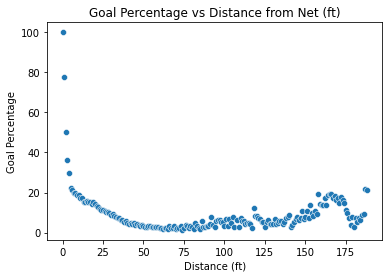

In [60]:
df_normalized['distance_1ft'] = df_normalized['distance'].round()

df_goals_only = df_normalized[df_normalized['eventType'] == 'Goal']
score_percentage_by_distance = (
    df_goals_only.groupby(['distance_1ft'])['eventType'].count() / 
    df_normalized.groupby(['distance_1ft'])['eventType'].count()
) * 100
score_percentage_by_distance = score_percentage_by_distance.rename_axis('Distance (ft)')
score_percentage_by_distance = score_percentage_by_distance.rename('Goal Percentage')

sns.scatterplot(x=score_percentage_by_distance.index, y=score_percentage_by_distance)
plt.title('Goal Percentage vs Distance from Net (ft)')

In [67]:
def plot_events_hostogram(
    events, season_year, normalize=False, title='', marker='o', size=100, color='#ea6969', alpha=.7
):
    fig, ax = plt.subplots(figsize=(13,8.5))
    plt.axis('on')

    events = events.copy()
    events['distance_1ft'] = events['distance'].round()

    events_goals_only = events[events['eventType'] == 'Goal']
    score_percentage_by_distance = (
        events_goals_only.groupby(['distance_1ft'])['eventType'].count() / 
        events.groupby(['distance_1ft'])['eventType'].count()
    ) * 100
    score_percentage_by_distance = score_percentage_by_distance.rename_axis('Distance (ft)')
    score_percentage_by_distance = score_percentage_by_distance.rename('Goal Percentage')

    sns.scatterplot(x=score_percentage_by_distance.index, y=score_percentage_by_distance)
    plt.title(f'Goal Percentage vs Distance from Net (ft) for {season_year}')


@interact(
    season_year=widgets.IntSlider(min=2016, max=2020, step=1),
    game_type=game_types,
)
def show_data(season_year, game_type):
    season_data = df_normalized[(df_normalized['season'] == season_year) & (df_normalized['gameType'] == game_type)]
    plot_events_hostogram(season_data, season_year)



interactive(children=(IntSlider(value=2016, description='season_year', max=2020, min=2016), Dropdown(descripti…

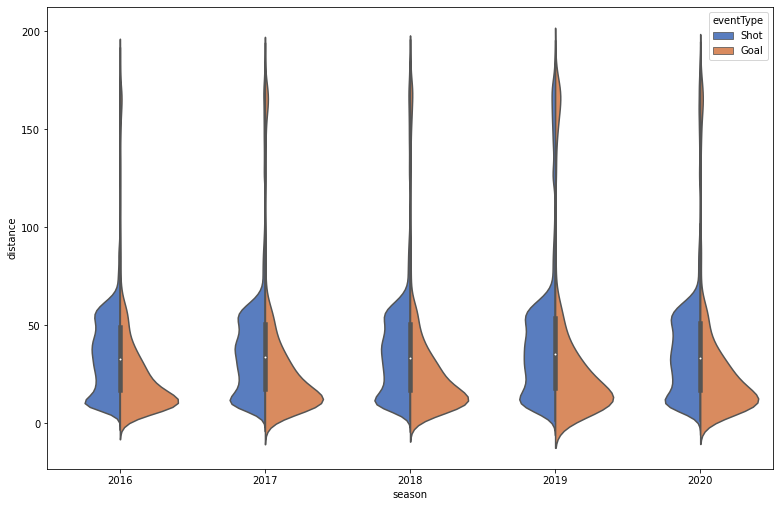

In [9]:
fig, ax = plt.subplots(figsize=(13,8.5))
plt.axis('on')

ax = sns.violinplot(x="season", y="distance", hue="eventType",
                data=df_normalized, palette="muted", split=True)

In [11]:
def plot_team_events(events, normalize=False, title='', marker='o', size=100, color='#ea6969', alpha=.7):
    fig, ax = plt.subplots(figsize=(13,8.5))
    plt.axis('on')

    img = plt.imread('../figures/nhl_rink.png')
    # rink dimensions
    ext = [-100, 100, -42.5, 42.5]
    plt.imshow(img, zorder=0, extent=ext, aspect=1)

    # plot the points on top of the image
    xLabel, yLabel = ('xCoordNorm', 'yCoordNorm') if normalize else ('xCoord', 'yCoord')
    plt.scatter(event[xLabel], event[yLabel], s=size, c=color, alpha=alpha, marker=marker, label='shot')

    # plot the opposing team's net
    net_x, net_y = (89, 0) if (event['rinkSide'] == 'left') or normalize else (-89, 0)
    plt.scatter(net_x, net_y, s=200, c='blue', alpha=alpha, marker='x', label='net')
    plt.xlabel('feet')
    plt.ylabel('feet')
    plt.title(title)
    plt.legend()


@interact(
    season_year=widgets.IntSlider(min=2016, max=2020, step=1),
    game_type=game_types,
)
def show_data(season_year, game_type):
    season_teams = teams[(season_year, game_type)]

    @interact(team_name=widgets.SelectionSlider(options=season_teams))
    def show_game(team_name):
        selected_team = df_normalized[df_normalized['teamOfShooter'] == team_name]
        print(selected_team)


interactive(children=(IntSlider(value=2016, description='season_year', max=2020, min=2016), Dropdown(descripti…